In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr
!pip uninstall -y botocore
!pip install botocore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 672.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 27.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
    Uninstalling transformers-4.42.3:
      Successfully uninstalled transformers-4.42.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 1.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 51.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.131
    Uninstalling botocore-1.34.131:
      Successfully uninstalled botocore-1.34.131
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.1 requires aiohttp<4.0.0,>=3.9.2, but you have aiohttp 3.9.1 which is incompatible.
aiobotocore 2.13.1 re

# Import Transformers, Dataset

In [2]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

2024-07-20 03:47:42.643508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 03:47:42.643643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 03:47:42.773001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Samsum Dataset

In [3]:
samsum_df = load_dataset('samsum')
samsum_df

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [5]:
samsum_df['train']['dialogue'][100]

"Gabby: How is you? Settling into the new house OK?\r\nSandra: Good. The kids and the rest of the menagerie are doing fine. The dogs absolutely love the new garden. Plenty of room to dig and run around.\r\nGabby: What about the hubby?\r\nSandra: Well, apart from being his usual grumpy self I guess he's doing OK.\r\nGabby: :-D yeah sounds about right for Jim.\r\nSandra: He's a man of few words. No surprises there. Give him a backyard shed and that's the last you'll see of him for months.\r\nGabby: LOL that describes most men I know.\r\nSandra: Ain't that the truth! \r\nGabby: Sure is. :-) My one might as well move into the garage. Always tinkering and building something in there.\r\nSandra: Ever wondered what he's doing in there?\r\nGabby: All the time. But he keeps the place locked.\r\nSandra: Prolly building a portable teleporter or something. ;-)\r\nGabby: Or a time machine... LOL\r\nSandra: Or a new greatly improved Rabbit :-P\r\nGabby: I wish... Lmfao!"

In [6]:
samsum_df['train']['summary'][100]

'Sandra is setting into the new house; her family is happy with it. Then Sandra and Gabby discuss the nature of their men and laugh about their habit of spending time in the garage or a shed.'

In [8]:
samsum_df['validation']['dialogue'][30]

"Toby: Hi, when are you leaving?\r\nTheo: on Friday.\r\nToby: Soon!\r\nTheo: soonish\r\nToby: Where are you going? decided?\r\nTheo: I was thinking about the Italian Alpes\r\nToby: where exactly? \r\nTheo: close to Torino I guess\r\nToby: Do you have a free seat in the car?\r\nTheo: I think we still do\r\nToby: So maybe I would join you, just for the weekend.\r\nTheo: That would be very nice!\r\nToby: And I would come back by train on Monday.\r\nTheo: Is it worth it, the journey?\r\nToby: I haven't beed skiing for years, I really miss it\r\nTheo: ok, but we want to depart before 7am, will you manage?\r\nToby: if you could pick my up, or at least come to my neighbourhood...\r\nTheo: That's not a problem!\r\nToby: Great!\r\nTheo: I'll write you later about all the details."

In [9]:
samsum_df['validation']['summary'][30]

"Theo's going to stay near Torino in the region of Italian Alpes. Toby wants to join the trip. Theo agrees and will pick Toby up on Friday at 7 am."

# Text Cleaning

In [14]:
import re

def clean_text(text):
    # Remove Byte Order Marks (BOM)
    text = text.replace('\ufeff', '')
    # Replace \n with a space
    text = text.replace('\n', ' ')
    # Replace \r with a space
    text = text.replace('\r', ' ')
    # Remove backslashes
    text = text.replace('\\', '')
    # Remove Non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove Non-printable characters
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

In [15]:
# Clean text for train dataset
samsum_df['train'] = samsum_df['train'].map(lambda x: {'dialogue': clean_text(x['dialogue'])})

# Clean text for validation dataset
samsum_df['validation'] = samsum_df['validation'].map(lambda x: {'dialogue': clean_text(x['dialogue'])})

# Clean text for test dataset
samsum_df['test'] = samsum_df['test'].map(lambda x: {'dialogue': clean_text(x['dialogue'])})


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [16]:
samsum_df['validation']['dialogue'][30]

"Toby: Hi, when are you leaving? Theo: on Friday. Toby: Soon! Theo: soonish Toby: Where are you going? decided? Theo: I was thinking about the Italian Alpes Toby: where exactly? Theo: close to Torino I guess Toby: Do you have a free seat in the car? Theo: I think we still do Toby: So maybe I would join you, just for the weekend. Theo: That would be very nice! Toby: And I would come back by train on Monday. Theo: Is it worth it, the journey? Toby: I haven't beed skiing for years, I really miss it Theo: ok, but we want to depart before 7am, will you manage? Toby: if you could pick my up, or at least come to my neighbourhood... Theo: That's not a problem! Toby: Great! Theo: I'll write you later about all the details."

# Load Model

In [17]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [18]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum_df['train']]
summary_len = [len(x['summary'].split()) for x in samsum_df['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

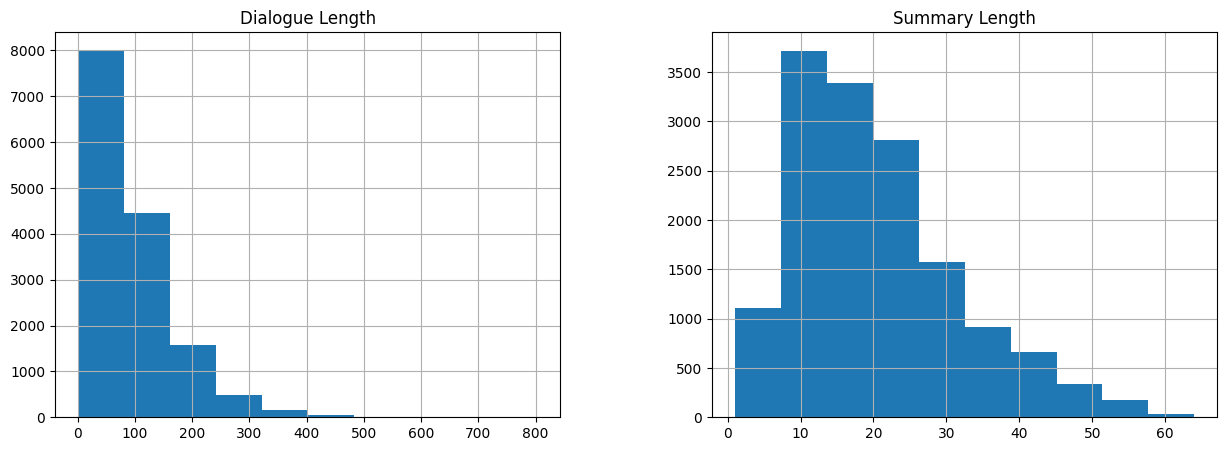

In [19]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

# Make Features

In [20]:
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [21]:
samsum_pt = samsum_df.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [22]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [23]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [24]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Model Training

In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum_5',
    num_train_epochs=2,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    load_best_model_at_end = True
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)  # Adjust patience as needed


trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'],callbacks=[early_stopping_callback])

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
50,1.526700,1.510433
100,1.390300,1.422089
150,1.287000,1.389398
200,1.276400,1.352196


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=230, training_loss=1.4225341631018598, metrics={'train_runtime': 3250.5316, 'train_samples_per_second': 9.064, 'train_steps_per_second': 0.071, 'total_flos': 1.856077686295757e+16, 'train_loss': 1.4225341631018598, 'epoch': 1.997828447339848})

# Saving the Model

In [37]:
trainer.save_model('bart_samsum_model_5')
tokenizer.save_pretrained("bart_samsum_model_5")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('bart_samsum_model_5/tokenizer_config.json',
 'bart_samsum_model_5/special_tokens_map.json',
 'bart_samsum_model_5/vocab.json',
 'bart_samsum_model_5/merges.txt',
 'bart_samsum_model_5/added_tokens.json',
 'bart_samsum_model_5/tokenizer.json')

In [28]:
!pip install rouge-score
!pip install datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a69ddf1663ec4e38a560e1d4907f1493314633798fbf3f86251cce2f24a5d281
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Testing on Custom Text

In [38]:
pipe = pipeline('summarization', model='bart_samsum_model_5')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "min_length": 30}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 142, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


[{'summary_text': 'Juli wants to send Tom on a business trip first. He will assign a new project to Tom once he is back. '}]


# Testing on Test dataset

In [31]:
from datasets import load_metric, load_dataset
from transformers import pipeline

# Load ROUGE metric
rouge = load_metric('rouge')

# Load samsum dataset
# samsum = load_dataset('samsum')

# Initialize summarization pipeline
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline('summarization', model='/kaggle/working/bart_samsum_model_5', device=device)

# Function to generate summaries
def generate_summary(text, gen_kwargs):
    summary = pipe(text, **gen_kwargs)
    return summary[0]['summary_text']

# Lists to store references and generated summaries
references = samsum_df['test']['summary']
generated_summaries = []

# Generate summaries for your dataset
for dialogue in samsum_df['test']['dialogue']:
    input_length = len(dialogue.split())
    max_length = max(10, min(142, input_length // 2))
    generated_summary = generate_summary(dialogue, gen_kwargs={'min_length': 30, 'max_length': max_length, 'num_beams': 4})
    generated_summaries.append(generated_summary)

# Compute ROUGE scores
results = rouge.compute(predictions=generated_summaries, references=references)

# Print the results
for key in results.keys():
    print(f"{key}: {results[key].mid}")

/tmp/ipykernel_34/2165442090.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your min_length=30 must be inferior than your max_length=28.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (28). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Your min_length=30 must be inferior than your max_length=12.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (12). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Your min_length=30 must be inferior than your max_length=22.
/opt/conda/lib/python3.10/site-packages/

rouge1: Score(precision=0.5240761726639174, recall=0.5164609406411964, fmeasure=0.48813699709755287)
rouge2: Score(precision=0.2750003463132431, recall=0.26328277298441694, fmeasure=0.2498681871552253)
rougeL: Score(precision=0.4338563417029981, recall=0.42507261340158575, fmeasure=0.40241707690768413)
rougeLsum: Score(precision=0.4330077769824946, recall=0.42511422355384887, fmeasure=0.4021251370419605)


In [33]:
import pandas as pd

# Assuming you have generated summaries in generated_summaries list and references list is already defined
# Create a DataFrame to store the results
df_results = pd.DataFrame({
    'reference': references,
    'generated_summary': generated_summaries
})

# Save the results to a CSV file
df_results.to_csv('summaries_results.csv', index=False)

# Optionally, save ROUGE scores to another file
rouge_scores = {key: results[key].mid for key in results.keys()}
df_rouge = pd.DataFrame(rouge_scores.items(), columns=['metric', 'score'])
df_rouge.to_csv('rouge_scores.csv', index=False)

In [34]:
df_results

,reference,generated_summary
0,Hannah needs Betty's number but Amanda doesn't...,Hannah doesn't have Betty's number. Amanda ask...
1,Eric and Rob are going to watch a stand-up on ...,Rob will watch some stand-up comedy by Russian...
2,Lenny can't decide which trousers to buy. Bob ...,Lenny will buy the first or the third pair of ...
3,Emma will be home soon and she will let Will k...,Emma will be home soon. She will tell Will wha...
4,Jane is in Warsaw. Ollie and Jane has a party....,Jane is back from Morocco. Ollie and Jane will...
...,...,...
814,Benjamin didn't come to see a basketball game ...,Benjamin was unable to attend Friday night's b...
815,The audition starts at 7.30 P.M. in Antena 3.,Jamilla reminds Kiki
816,"Marta sent a file accidentally,",Marta accidentally sent Weronika and Agnies
817,There was a meet-and-greet with James Charles ...,There was a meet and greet with James Charles ...


In [35]:
df_rouge

,metric,score
0,rouge1,"(0.5240761726639174, 0.5164609406411964, 0.488..."
1,rouge2,"(0.2750003463132431, 0.26328277298441694, 0.24..."
2,rougeL,"(0.4338563417029981, 0.42507261340158575, 0.40..."
3,rougeLsum,"(0.4330077769824946, 0.42511422355384887, 0.40..."
